In [1]:
import base64
from PIL import Image
import requests
import tempfile
import zipfile
import os
from imgcat import imgcat
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

api_key = ''

In [2]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
def get_caption(base64_image, api_key, tok, prefix):
    # Base prompt for direct description
    custom_prompt = "Directly describe with brevity and as brief as possible the scene or characters without any introductory phrase like 'This image shows', 'In the scene', 'This image depicts' or similar phrases. Just start describing the scene please. Do not end the caption with a '.'. Some characters may be animated, refer to them as regular humans and not animated humans. Please make no reference to any particular style or characters from any TV show or Movie. Good examples: a cat on a windowsill, a photo of smiling cactus in an office, a man and baby sitting by a window, a photo of wheel on a car,"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    payload = {
        "model": "gpt-4o-mini",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "What is in this image?"},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ]
            }
        ],
        "max_tokens": 300
    }

    try:
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        response.raise_for_status()
        response_json = response.json()

        if 'choices' in response_json and response_json['choices'] and 'message' in response_json['choices'][0]:
            caption = response_json['choices'][0]['message'].get('content', 'Caption not found').strip()
            # Determine style or action phrase based on prefix
            # Remove commas and double quotes from the caption
            caption = caption.replace(',', '').replace('"', '')
            style_or_action_phrase = f"in the style of {tok}" if prefix else f"{tok}"
            return f"{caption} {style_or_action_phrase}"
    except requests.RequestException as e:
        print(f"API request failed: {e}")
    return "Failed to get caption"

def process_images(input_path, output_csv, api_key, tok, prefix):
    with tempfile.TemporaryDirectory() as temp_dir:
        if zipfile.is_zipfile(input_path):
            with zipfile.ZipFile(input_path, 'r') as zip_ref:
                zip_ref.extractall(temp_dir)
            directory_to_process = temp_dir
        else:
            directory_to_process = input_path

        with open(output_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['caption', 'image_file'])  # Header row
            for root, _, files in os.walk(directory_to_process):
                for file_name in filter(lambda f: f.lower().endswith(('.png', '.jpg', '.jpeg')), files):
                    image_path = os.path.join(root, file_name)
                    base64_image = encode_image(image_path)
                    caption = get_caption(base64_image, api_key, tok, prefix)
                    # imgcat(open(image_path, 'rb').read())
                    img = mpimg.imread(image_path)
                    plt.imshow(img)
                    plt.axis('off')  # Tắt hiển thị trục
                    plt.show()
                    print(f"Caption: {caption}\n")
                    writer.writerow([caption, file_name])



API request failed: 429 Client Error: Too Many Requests for url: https://api.openai.com/v1/chat/completions


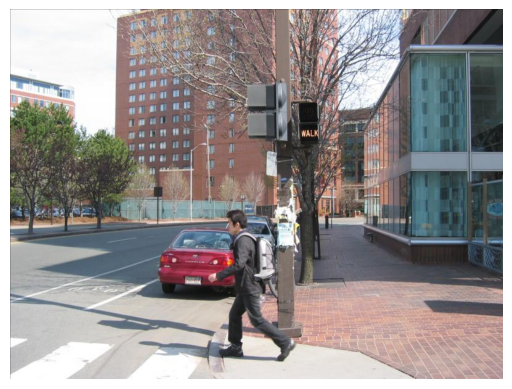

Caption: Failed to get caption

Processing complete. Captions saved to caption.csv


In [3]:
input_path = '/home/duypd/ThisPC-DuyPC/SG-Retrieval/Datasets/upload_2'
output_csv = "caption.csv"
tok = 'TOK'
prefix = 'y'
prefix = "in the style of" if prefix.lower() == 'y' else prefix
if not api_key:
    raise ValueError("OpenAI API key not found. Set the OPENAI_API_KEY environment variable.")

process_images(input_path, output_csv, api_key, tok, prefix)
print("Processing complete. Captions saved to", output_csv)